In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [3]:
# explorer db to get more info about data
inspector = inspect(engine)

# get table names
print(inspector.get_table_names())

['measurement', 'station']


In [4]:
# get column names and their data types for 'measurement' table
measurement_columns = inspector.get_columns('measurement')
print("Measurment table column's names:")
for col in measurement_columns:
    print(col['name'], col['type'])


Measurment table column's names:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# get column names and their data types for 'station' table

station_columns = inspector.get_columns('station')
print("Station table column's names")
for col in station_columns:
    print(col['name'], col['type'])

Station table column's names
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Reflect db into ORM class

Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# Reference to measurment and stations

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
session = Session(engine)

In [9]:
#Earliest measurement date
measurement_earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(f"Earliest date in Measurement table is {measurement_earliest_date}")


Earliest date in Measurement table is ('2010-01-01',)


In [10]:
#Latest measurement date
measurement_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Latest measurement date is {measurement_latest_date[0]}")


Latest measurement date is 2017-08-23


In [12]:
import datedelta

end_date = dt.date(2017, 8, 23) - datedelta.YEAR
print(end_date)

2016-08-23


In [22]:
# retrieve the last 12 months of precipitation data

prcp_by_date = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date <= measurement_latest_date[0])\
                    .filter(Measurement.date >= end_date).order_by(Measurement.date).all()

prcp_by_date

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [14]:
prcp_by_date_df = pd.DataFrame(prcp_by_date, columns=['date', 'prcp'])
prcp_by_date_df.set_index('date', inplace=True)
prcp_by_date_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


In [15]:
# remove rows with NaN 
prcp_by_date_df.dropna(inplace=True)

# group by by date
prcp_by_date_df = prcp_by_date_df.groupby(by='date').sum()


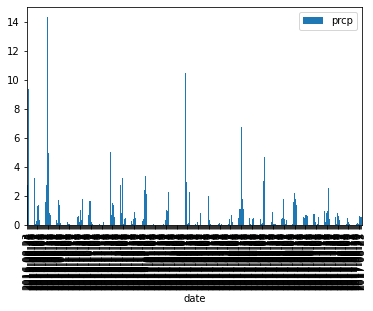

In [16]:
prcp_by_date_df.plot.bar()
plt.show()

In [17]:
# Summary statistics

prcp_by_date_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [23]:
# Stations

# get column names and their data types for 'station' table

station_columns = inspector.get_columns('station')
print("Station table column's names")
for col in station_columns:
    print(col['name'], col['type'])
    

Station table column's names
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [28]:
session.query(Station.id, Station.station, Station.name).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [35]:
# Total number of stations
station_count = session.query(func.count(Station.name)).all()
print(f"The count of available stations are {station_count}")

The count of available stations are [(9,)]


In [49]:
# Station activity
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# Min, Max and Avg temprature that was observed on the most active station 
obs = session.query(func.min(Measurement.tobs)\
                            , func.max(Measurement.tobs)\
                            , func.avg(Measurement.tobs))
                            .filter(Measurement.station == station_activity[0][0]).all()
obs

[(54.0, 85.0, 71.66378066378067)]